# Layer-wise Relevance Propagation using Abstract Semiring elements for the MNIST Dataset

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import ProvLRP
import ProvLRP_config
from importlib import reload
reload(ProvLRP)

<module 'ProvLRP' from '/Users/antoinegroudiev/Documents/Travail/L3-Internship/code/ProvLRP.py'>

## 0. Load dataset

In [4]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [6]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 1. Train simple model

In [7]:
# Select the best device to use

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [9]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [10]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [11]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35751 | Test loss: 0.14882, Test acc: 95.47%


## 2. Layer-wise Relevance Propagation

In [12]:
semiring = ProvLRP.Semiring

### 2.0 Preparing for LRP

In [13]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

In [14]:
SUBSET = 20

X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

In [15]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

### 2.1 Using $z^\mathcal{B}$

In [16]:
nb_digits = len(train.classes)
R = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

General rule for the hidden and output layers:
$$
R^{(l)}_j = \bigoplus_k \Theta_a(a^{(l)}_j) \otimes\Theta_w(w^{(l)}_{jk}) \otimes R^{(l+1)}_k
$$

In [17]:
def rho(w, l):  return w

Four steps of computing the relevance:
$$
\begin{align*}
\forall k:~s_k &= \Theta_R(R_k) \qquad & (\text{step }1)\\
\forall j:~c_j &= \bigoplus_k \rho(\Theta_w(w_{jk})) \otimes s_k \qquad & (\text{step }2)\\
\forall j:~R_j &= \Theta_A(a_j) \otimes c_j \qquad & (\text{step }3)
\end{align*}
$$

In [18]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)
    #b = rho(B[l], l)

    #z = incr(A[l].dot(w)+b, l)
    s = R[l+1] #/ z
    c = s.dot(w.T)
    R[l] = semiring.from_activation(A[l]) * c

$z^\mathcal{B}$ rule for the input layer:
$$R_i = \sum_j \frac{a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{i} a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j$$

In [19]:
w = semiring.from_weight(W[0])
wp = semiring.vect_pos(w)
wm = semiring.vect_neg(w)
lb = semiring.lower_bound(A[0].shape, -1)
hb = semiring.upper_bound(A[0].shape, 1)

s = R[1]
c = s @ w.T
cp = s @ (wp.T)
cm = s @ (wm.T)
R[0] = semiring.from_activation(A[0])*c - lb*cp - hb*cm

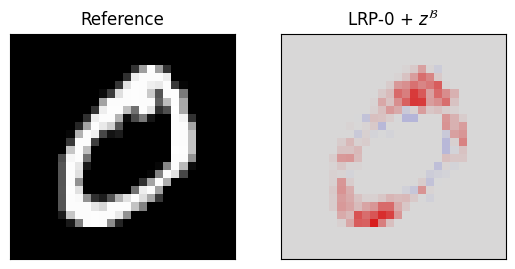

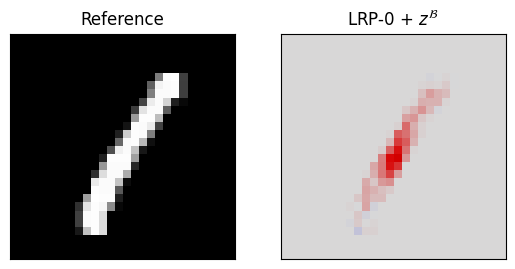

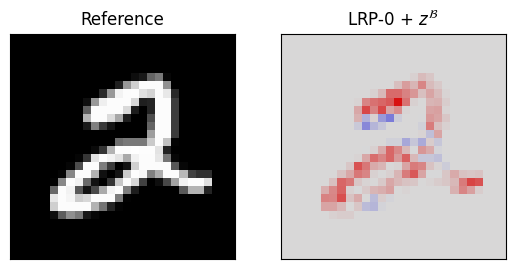

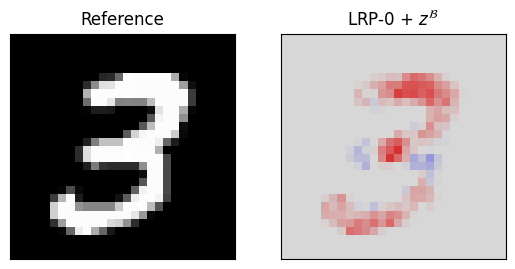

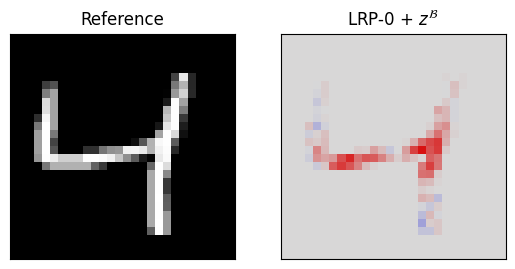

In [20]:
Rf = [semiring.semiring_to_float(x) for x in R]

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    fig, axs = plt.subplots(1, 2)
    for j in range(2):
        axs[j].set_xticks([]); axs[j].set_yticks([])

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")
    axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    axs[1].set_title("LRP-0 + $z^\\mathcal{B}$")
    plt.show()

#### 2.2 Without $z^\mathcal{B}$
Computations:

In [21]:
R_wozB = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_wozB[l+1]
    c = s.dot(w.T)
    R_wozB[l] = semiring.from_activation(A[l]) * c

Visualization:

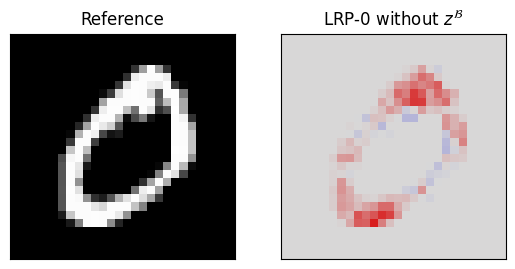

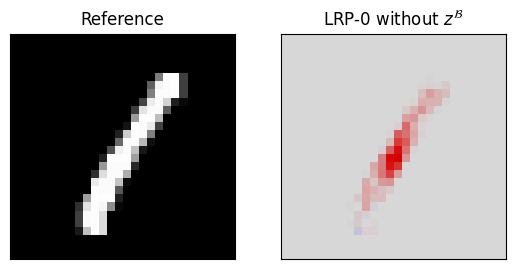

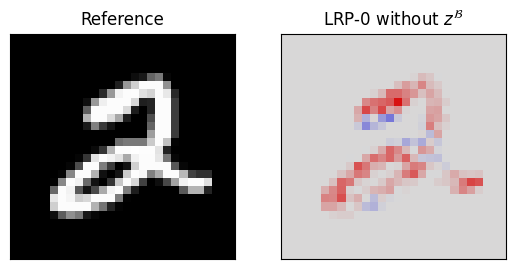

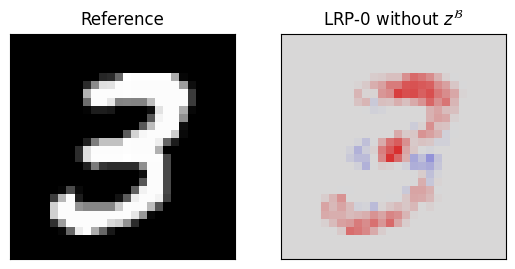

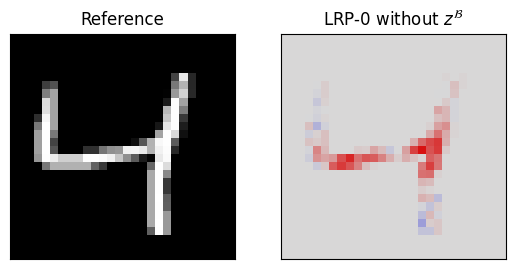

In [22]:
Rf = [semiring.semiring_to_float(x) for x in R_wozB]

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    fig, axs = plt.subplots(1, 2)
    for j in range(2):
        axs[j].set_xticks([]); axs[j].set_yticks([])

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")
    axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    axs[1].set_title("LRP-0 without $z^\\mathcal{B}$")
    plt.show()

## 3. Exploring different semirings
### 3.1 Boolean semiring
The considered semiring is:
$$(\{\bot, \top\}, \lor, \land, \bot, \top)$$
Conversion functions $\Theta_{a, w, r}$ are threshold-based, that is for example:
$$
\Theta_a^{(l)}(x) = \begin{cases}
    \top & \textnormal{if} \quad x\geq\theta_a^{(l)} \\
    \bot & \textnormal{otherwise}
\end{cases}
$$
where $\theta_a$ is some hand-picked threshold, by default 1 in the code. Those parameters are ajustable in `ProvLRP_config.py`.

In [23]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.BooleanSemiring

ProvLRP_config.boolean_relevance_threshold = 0.5

ProvLRP_config.boolean_activation_threshold = 1
ProvLRP_config.boolean_weight_threshold = 0

R_bool = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_bool[l+1]
    c = s.dot(w.T)
    R_bool[l] = semiring.from_activation(A[l]) * c

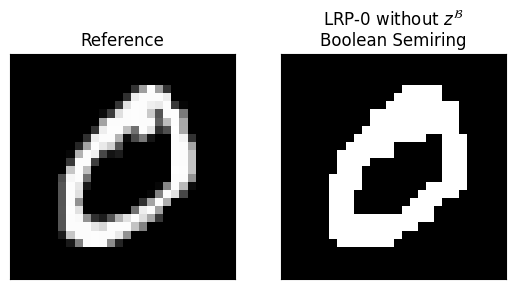

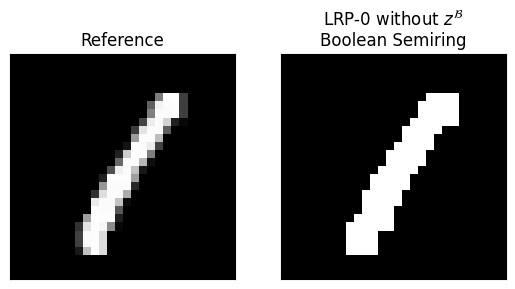

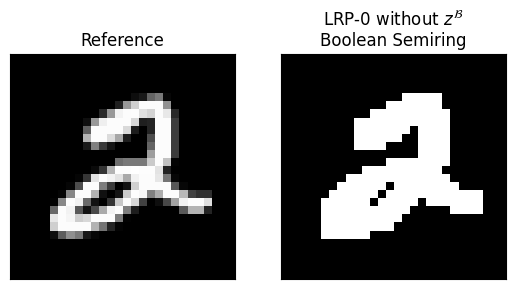

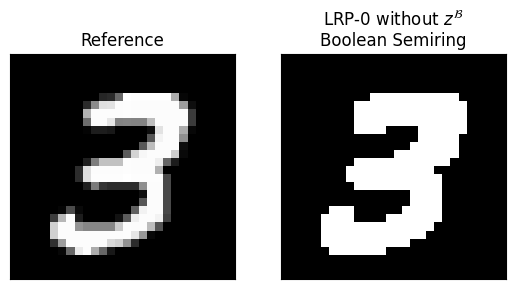

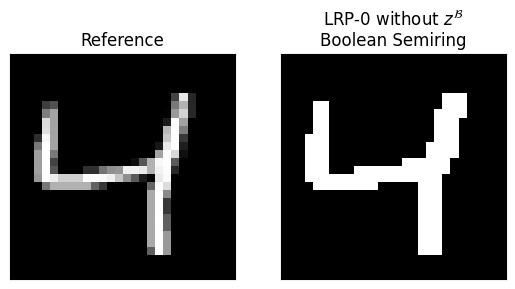

In [24]:
Rf = [semiring.semiring_to_float(x) for x in R_bool]

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    fig, axs = plt.subplots(1, 2)
    for j in range(2):
        axs[j].set_xticks([]); axs[j].set_yticks([])

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")

    axs[1].imshow(image, cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("LRP-0 without $z^\\mathcal{B}$\nBoolean Semiring")

    plt.show()

#### Influence of the thresholds

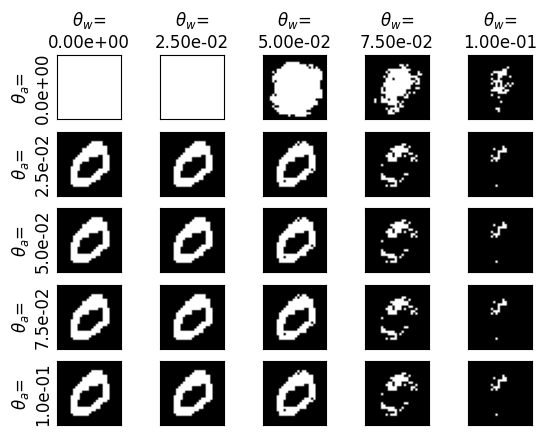

In [169]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.BooleanSemiring

ProvLRP_config.boolean_relevance_threshold = 0.5
activation_thresholds = np.linspace(0, 0.1, 5)
weight_thresholds = np.linspace(0, 0.1, 5)

fig, axs = plt.subplots(len(activation_thresholds), len(weight_thresholds))

for ax, i in zip(axs[0], range(len(weight_thresholds))):
    ax.set_title(f"$\\theta_w$=\n{weight_thresholds[i]:0.2e}")

for ax, j in zip(axs[:,0], range(len(activation_thresholds))):
    ax.set_ylabel(f"$\\theta_a$=\n{activation_thresholds[j]:0.1e}", size='large')

for i, theta_a in enumerate(activation_thresholds):
    for j, theta_w in enumerate(weight_thresholds):
        ProvLRP_config.boolean_activation_threshold = theta_a
        ProvLRP_config.boolean_weight_threshold = theta_w
        
        R_bool = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

        # All layers, even the pixels one
        for l in range(0, L)[::-1]:
            w = rho(semiring.from_weight(W[l]), l)

            s = R_bool[l+1]
            c = s.dot(w.T)
            R_bool[l] = semiring.from_activation(A[l]) * c

        Rf = [semiring.semiring_to_float(x) for x in R_bool]
        image = Rf[0][T==0][0].reshape((28, 28))

        axs[i][j].imshow(image, cmap="gray", vmin=0, vmax=1)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

plt.show()

### 3.2 Tropical Semiring
The considered semiring is:
$$(\mathbb{R}^+\cup\{\infty\}, \min, +, \infty, 0)$$

In [24]:
reload(ProvLRP)
semiring = ProvLRP.TropicalSemiring

R_trop = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_trop[l+1]
    c = s.dot(w.T)
    R_trop[l] = semiring.from_activation(A[l]) * c

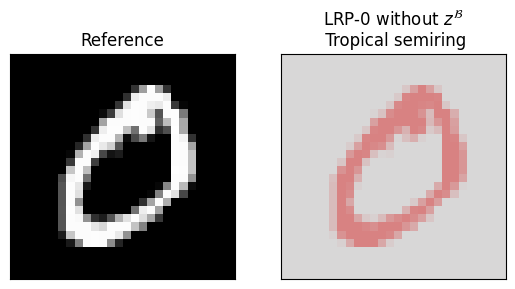

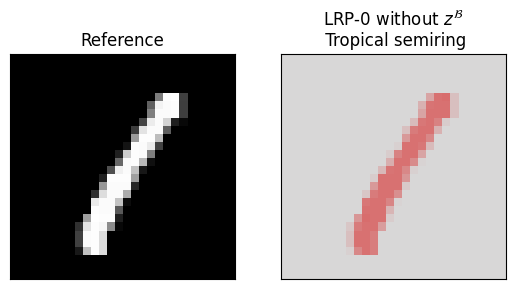

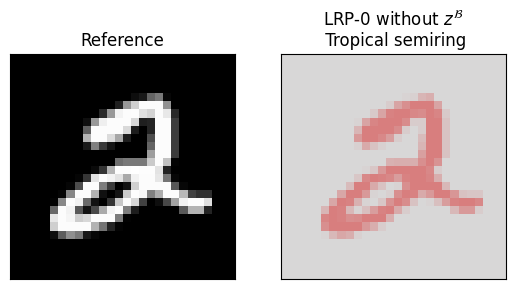

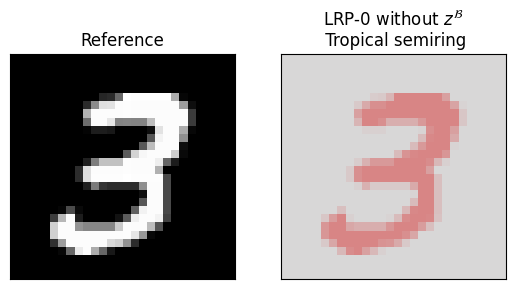

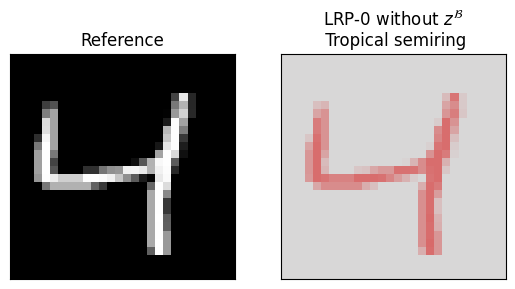

In [25]:
Rf = [semiring.semiring_to_float(x) for x in R_trop]

my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    fig, axs = plt.subplots(1, 2)
    for j in range(2):
        axs[j].set_xticks([]); axs[j].set_yticks([])

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)
    axs[1].imshow(image, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[1].set_title("LRP-0 without $z^\\mathcal{B}$\n Tropical semiring")

    plt.show()

### 3.3 Counting semiring

In [26]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.CountingSemiring

ProvLRP_config.counting_relevance_threshold = 0.5
ProvLRP_config.counting_activation_threshold = 0.1
ProvLRP_config.counting_weight_threshold = 0

R_count = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_count[l+1]
    c = s.dot(w.T)
    R_count[l] = semiring.from_activation(A[l]) * c

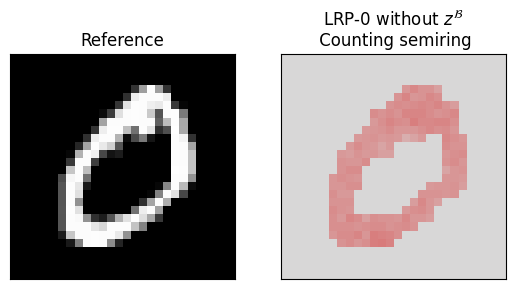

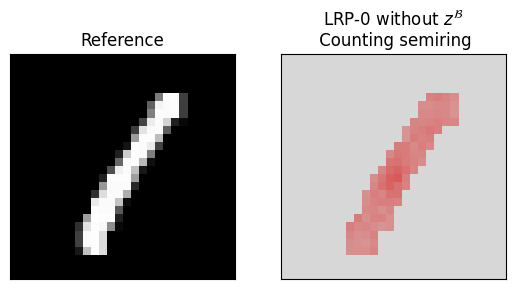

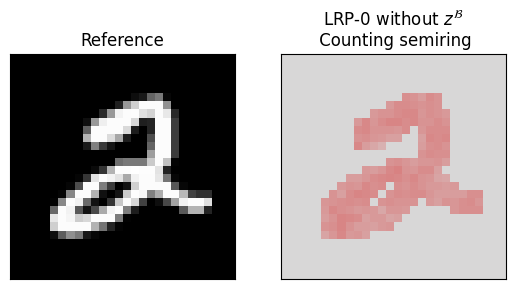

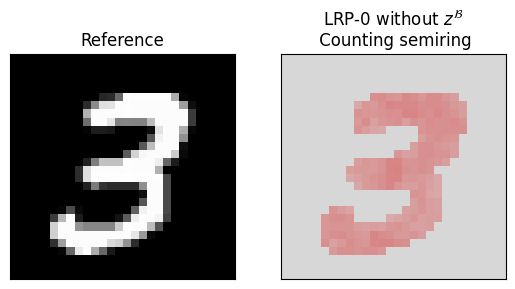

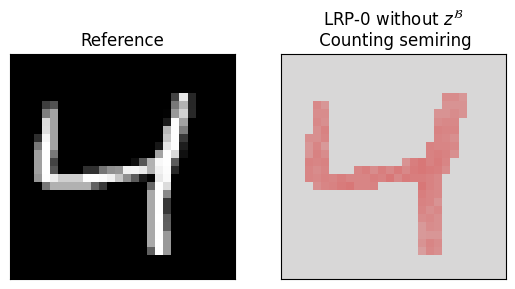

In [27]:
Rf = [semiring.semiring_to_float(x) for x in R_count]

my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    fig, axs = plt.subplots(1, 2)
    for j in range(2):
        axs[j].set_xticks([]); axs[j].set_yticks([])

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)
    axs[1].imshow(image, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[1].set_title("LRP-0 without $z^\\mathcal{B}$\n Counting semiring")

    plt.show()

## 4. Full Dataset Exploration
The goal of this part is to use the results of ProvLRP (for example of boolean semiring) and to apply an operation on all images of the class (for example, using a global OR/AND over all the results of the boolean semiring). This allows for instance to find the minimal hull of interesting pixels.

### 4.1. Boolean Semiring
The operations used for this are simply $\land$ and $\lor$, that is:
$$R^{\land}[i] = \bigwedge_j R^{(0)}_j[i]$$
where $R^{(0)}_j$ is the $j$-th image of the training set, and $R^{(0)}_j[i]$ its $i$-th pixel. Similarly:
$$R^{\lor}[i] = \bigvee_j R^{(0)}_j[i]$$

In [33]:
SUBSET = 10*100

X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [34]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.BooleanSemiring

ProvLRP_config.boolean_relevance_threshold = 0.5

ProvLRP_config.boolean_activation_threshold = 1
ProvLRP_config.boolean_weight_threshold = 0

R_bool = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_bool[l+1]
    c = s.dot(w.T)
    R_bool[l] = semiring.from_activation(A[l]) * c

Rf = [semiring.semiring_to_float(x) for x in R_bool]

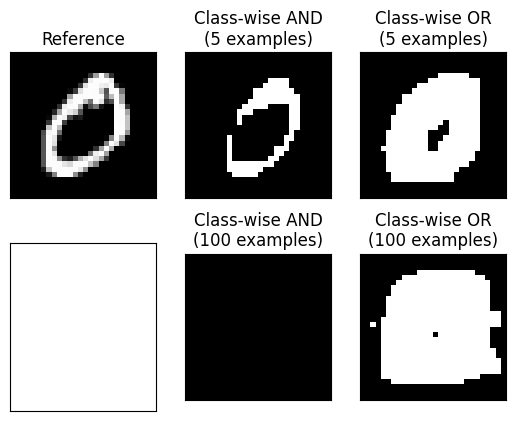

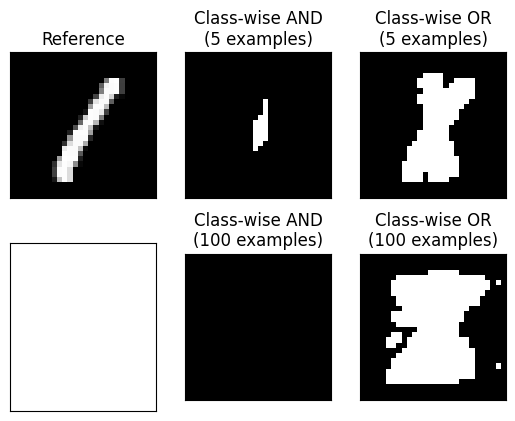

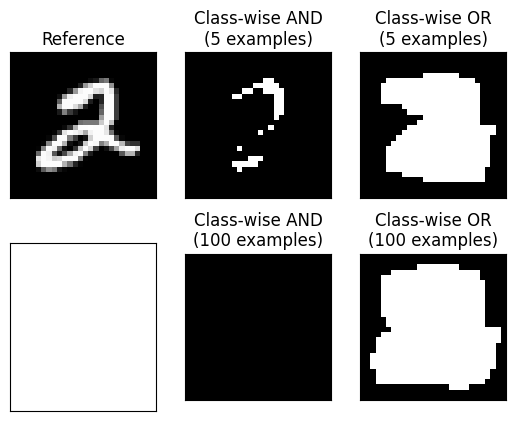

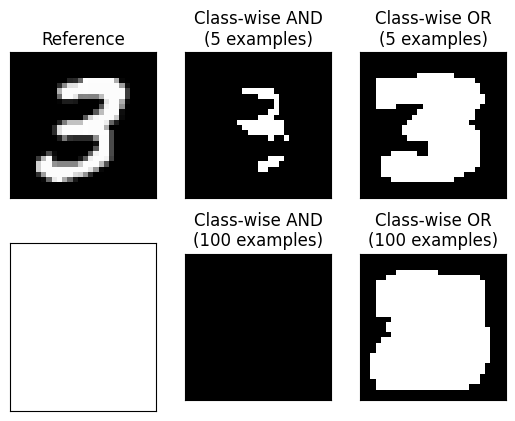

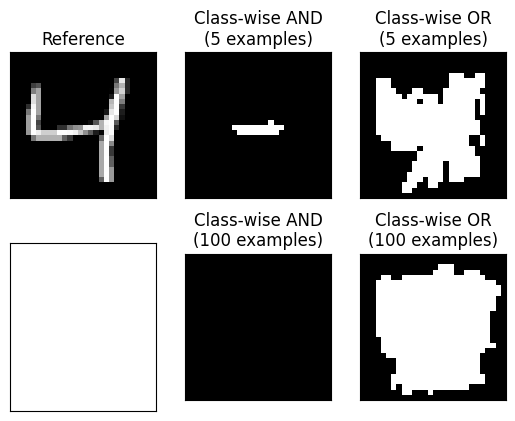

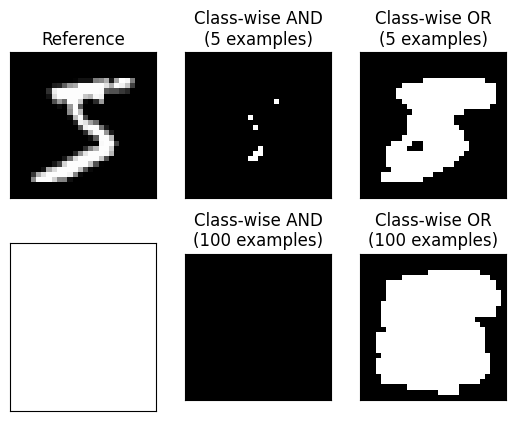

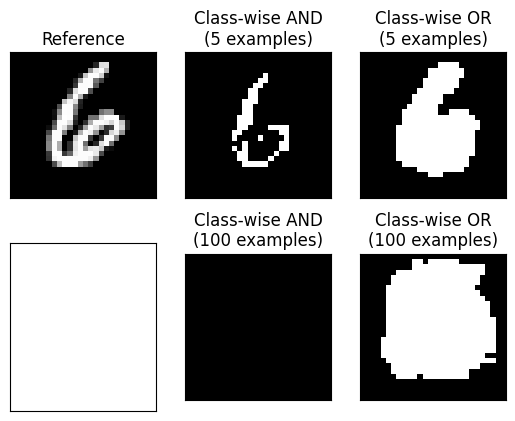

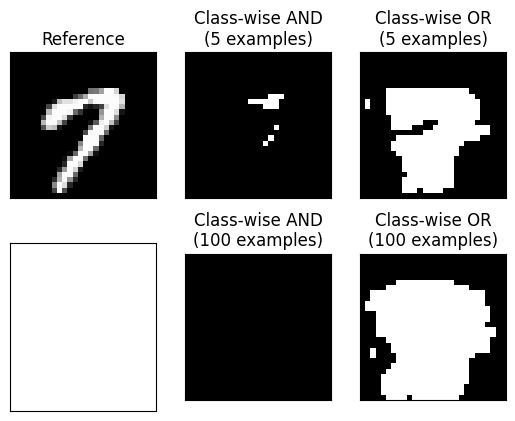

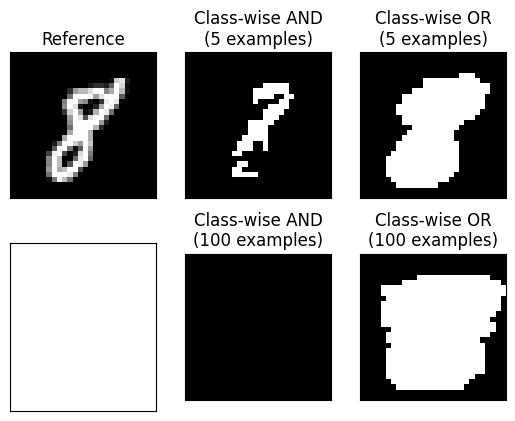

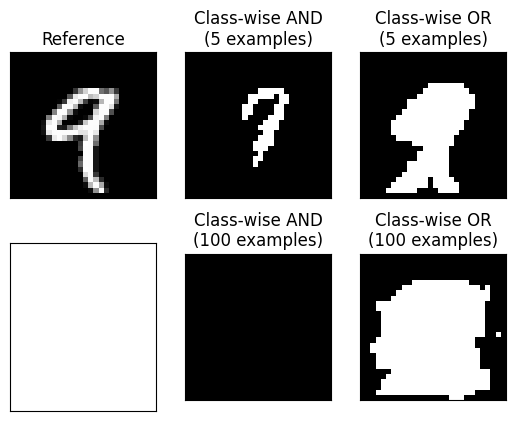

In [35]:
DIGITS = 10
NB_IMAGES_1 = 5
NB_IMAGES_2 = 100
for i in range(DIGITS):
    images = np.copy(Rf[0][T==i])

    # AND
    image_and_1 = np.copy(images[0])
    for im in images[:NB_IMAGES_1]:
        image_and_1 *= im # Hadamard product - AND
    image_and_1 = image_and_1.reshape((28, 28))

    # OR
    image_or_1 = np.copy(images[0])
    for im in images[:NB_IMAGES_1]:
        image_or_1 += im # sum - OR
    image_or_1 = image_or_1.reshape((28, 28))

    # AND
    image_and_2 = np.copy(images[0])
    for im in images[:NB_IMAGES_2]:
        image_and_2 *= im # Hadamard product - AND
    image_and_2 = image_and_2.reshape((28, 28))

    # OR
    image_or_2 = np.copy(images[0])
    for im in images[:NB_IMAGES_2]:
        image_or_2 += im # sum - OR
    image_or_2 = image_or_2.reshape((28, 28))

    fig, axs = plt.subplots(2, 3)
    for j in range(3):
        for k in range(2):
            axs[k][j].set_xticks([]); axs[k][j].set_yticks([])

    axs[0][0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0][0].set_title("Reference")

    axs[0][1].imshow(image_and_1, cmap="gray", vmin=0, vmax=1)
    axs[0][1].set_title(f"Class-wise AND\n({NB_IMAGES_1} examples)")

    axs[0][2].imshow(image_or_1, cmap="gray", vmin=0, vmax=1)
    axs[0][2].set_title(f"Class-wise OR\n({NB_IMAGES_1} examples)")

    axs[1][1].imshow(image_and_2, cmap="gray", vmin=0, vmax=1)
    axs[1][1].set_title(f"Class-wise AND\n({NB_IMAGES_2} examples)")

    axs[1][2].imshow(image_or_2, cmap="gray", vmin=0, vmax=1)
    axs[1][2].set_title(f"Class-wise OR\n({NB_IMAGES_2} examples)")

    plt.show()

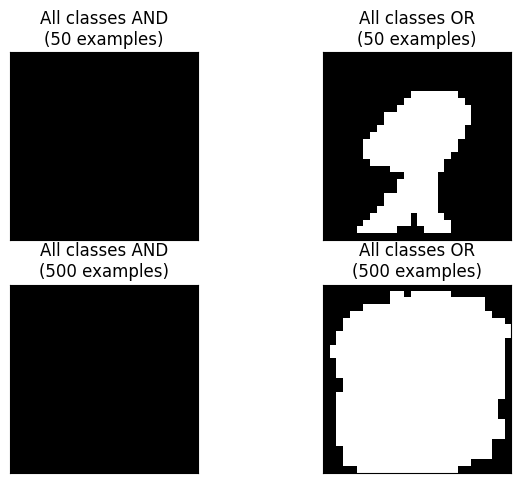

In [36]:
NB_IMAGES_1 = 50
NB_IMAGES_2 = 500

images = np.copy(Rf[0])

# AND
image_and_1 = np.copy(images[0])
for im in images:
    image_and_1 *= im # Hadamard product - AND
image_and_1 = image_and_1.reshape((28, 28))

# OR
image_or_2 = np.copy(images[0])
for im in images:
    image_or_2 += im # sum - OR
image_or_2 = image_or_2.reshape((28, 28))

# AND
image_and_2 = np.copy(images[0])
for im in images:
    image_and_2 *= im # Hadamard product - AND
image_and_2 = image_and_2.reshape((28, 28))

# OR
image_or_2 = np.copy(images[0])
for im in images:
    image_or_2 += im # sum - OR
image_or_2 = image_or_2.reshape((28, 28))

fig, axs = plt.subplots(2, 2)
fig.tight_layout()
for j in range(2):
    for k in range(2):
        axs[k][j].set_xticks([]); axs[k][j].set_yticks([])

axs[0][0].imshow(image_and_1, cmap="gray", vmin=0, vmax=1)
axs[0][0].set_title(f"All classes AND\n({NB_IMAGES_1} examples)")

axs[0][1].imshow(image_or_1, cmap="gray", vmin=0, vmax=1)
axs[0][1].set_title(f"All classes OR\n({NB_IMAGES_1} examples)")

axs[1][0].imshow(image_and_2, cmap="gray", vmin=0, vmax=1)
axs[1][0].set_title(f"All classes AND\n({NB_IMAGES_2} examples)")

axs[1][1].imshow(image_or_2, cmap="gray", vmin=0, vmax=1)
axs[1][1].set_title(f"All classes OR\n({NB_IMAGES_2} examples)")

plt.show()

### 4.2. Counting Semiring
The operations used for this are $\min$ and $\max$, that is:
$$R^{\min}[i] = \min_j R^{(0)}_j[i]$$
where $R^{(0)}_j$ is the $j$-th image of the training set, and $R^{(0)}_j[i]$ its $i$-th pixel. Similarly:
$$R^{\max}[i] = \max_j R^{(0)}_j[i]$$
Furthermore, the average was also represented.

In [37]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.CountingSemiring

ProvLRP_config.counting_relevance_threshold = 0.5
ProvLRP_config.counting_activation_threshold = 0.1
ProvLRP_config.counting_weight_threshold = 0

R_count = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_count[l+1]
    c = s.dot(w.T)
    R_count[l] = semiring.from_activation(A[l]) * c

Rf = [semiring.semiring_to_float(x) for x in R_count]

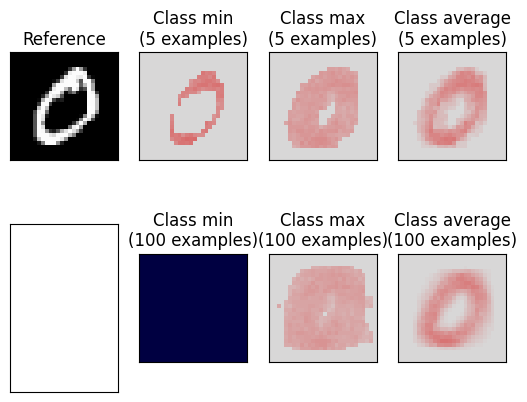

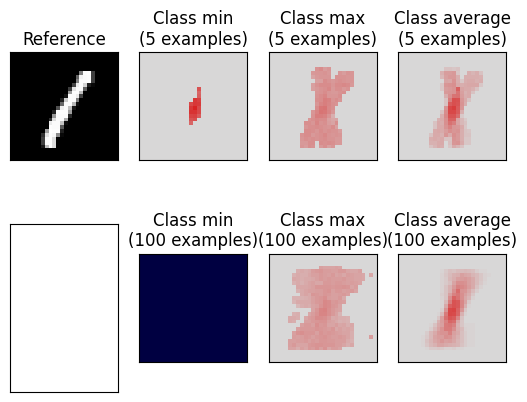

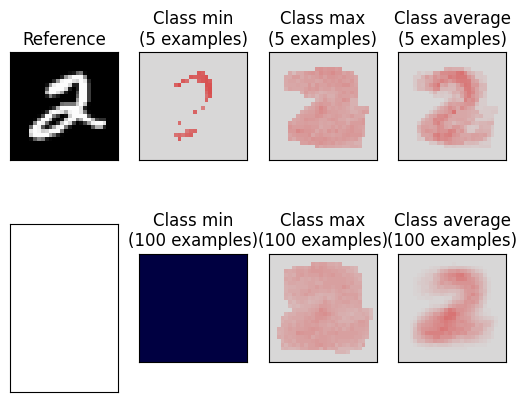

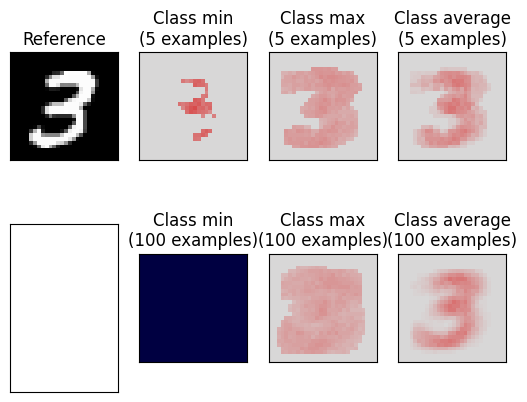

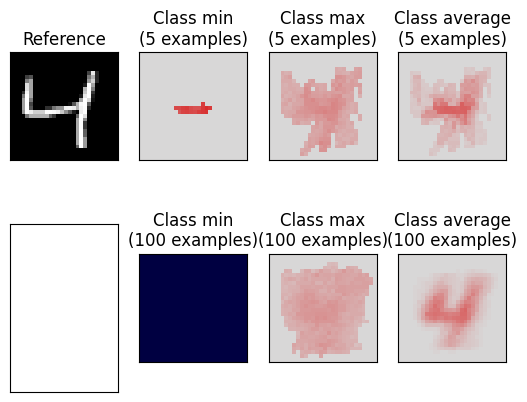

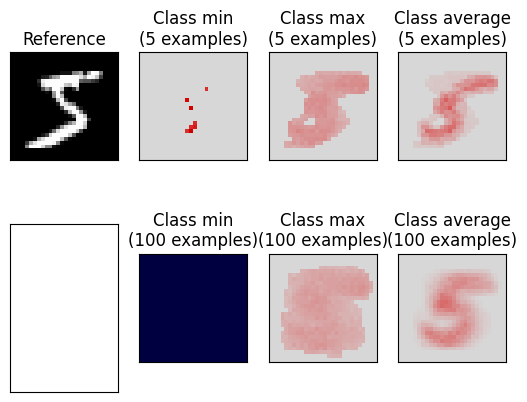

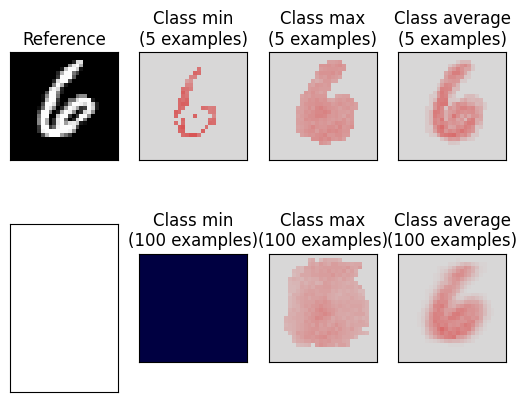

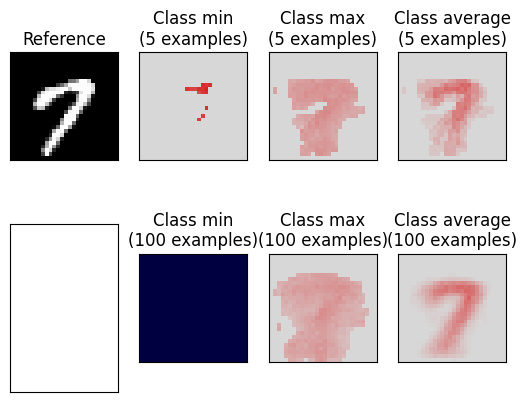

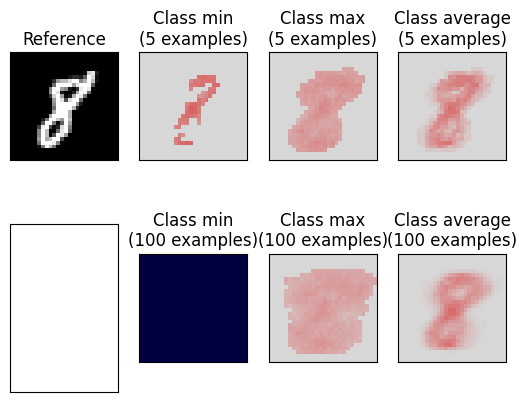

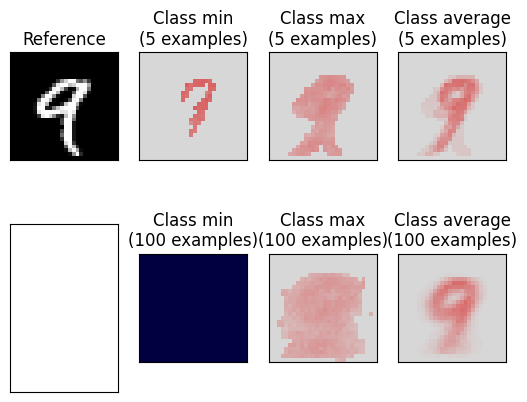

In [38]:
DIGITS = 10
NB_IMAGES_1 = 5
NB_IMAGES_2 = 100
for i in range(DIGITS):

    images = np.copy(Rf[0][T==i])

    # min
    image_min_1 = np.copy(images[0])
    for im in images[:NB_IMAGES_1]:
        image_min_1 = np.minimum(image_min_1, im)
    image_min_1 = image_min_1.reshape((28, 28))

    # max
    image_max_1 = np.copy(images[0])
    for im in images[:NB_IMAGES_1]:
        image_max_1 = np.maximum(image_max_1, im)
    image_max_1 = image_max_1.reshape((28, 28))

    # average
    image_avg_1 = np.mean(images[:NB_IMAGES_1], axis=0).reshape((28, 28))

    # min
    image_min_2 = np.copy(images[0])
    for im in images[:NB_IMAGES_2]:
        image_min_2 = np.minimum(image_min_2, im)
    image_min_2 = image_min_2.reshape((28, 28))

    # max
    image_max_2 = np.copy(images[0])
    for im in images[:NB_IMAGES_2]:
        image_max_2 = np.maximum(image_max_2, im)
    image_max_2 = image_max_2.reshape((28, 28))

    # average
    image_avg_2 = np.mean(images[:NB_IMAGES_2], axis=0).reshape((28, 28))

    fig, axs = plt.subplots(2, 4)
    for j in range(4):
        for k in range(2):
            axs[k][j].set_xticks([]); axs[k][j].set_yticks([])

    axs[0][0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0][0].set_title("Reference")

    b = 10*(np.abs(image_min_1)**3.0).mean()**(1.0/3)
    axs[0][1].imshow(image_min_1, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[0][1].set_title(f"Class min\n({NB_IMAGES_1} examples)")

    b = 10*(np.abs(image_max_1)**3.0).mean()**(1.0/3)
    axs[0][2].imshow(image_max_1, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[0][2].set_title(f"Class max\n({NB_IMAGES_1} examples)")

    b = 10*(np.abs(image_avg_1)**3.0).mean()**(1.0/3)
    axs[0][3].imshow(image_avg_1, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[0][3].set_title(f"Class average\n({NB_IMAGES_1} examples)")



    b = 10*(np.abs(image_min_2)**3.0).mean()**(1.0/3)
    axs[1][1].imshow(image_min_2, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[1][1].set_title(f"Class min\n({NB_IMAGES_2} examples)")

    b = 10*(np.abs(image_max_2)**3.0).mean()**(1.0/3)
    axs[1][2].imshow(image_max_2, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[1][2].set_title(f"Class max\n({NB_IMAGES_2} examples)")

    b = 10*(np.abs(image_avg_2)**3.0).mean()**(1.0/3)
    axs[1][3].imshow(image_avg_2, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[1][3].set_title(f"Class average\n({NB_IMAGES_2} examples)")

    plt.show()

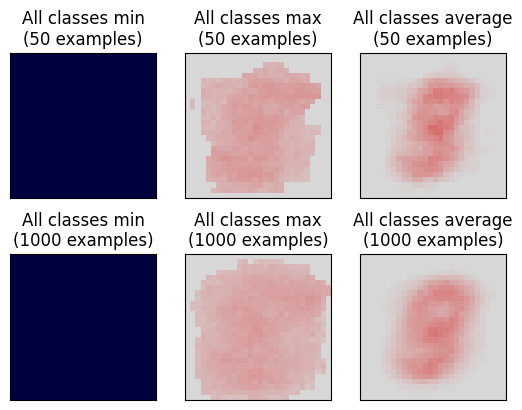

In [39]:
NB_IMAGES_1 = 50
NB_IMAGES_2 = 1000

images = np.copy(Rf[0])

# min
image_min_1 = np.copy(images[0])
for im in images[:NB_IMAGES_1]:
    image_min_1 = np.minimum(image_min_1, im)
image_min_1 = image_min_1.reshape((28, 28))

# max
image_max_1 = np.copy(images[0])
for im in images[:NB_IMAGES_1]:
    image_max_1 = np.maximum(image_max_1, im)
image_max_1 = image_max_1.reshape((28, 28))

# average
image_avg_1 = np.mean(images[:NB_IMAGES_1], axis=0).reshape((28, 28))




# min
image_min_2 = np.copy(images[0])
for im in images[:NB_IMAGES_2]:
    image_min_2 = np.minimum(image_min_2, im)
image_min_2 = image_min_2.reshape((28, 28))

# max
image_max_2 = np.copy(images[0])
for im in images[:NB_IMAGES_2]:
    image_max_2 = np.maximum(image_max_2, im)
image_max_2 = image_max_2.reshape((28, 28))

# average
image_avg_2 = np.mean(images[:NB_IMAGES_2], axis=0).reshape((28, 28))



fig, axs = plt.subplots(2, 3)
for j in range(3):
    for k in range(2):
        axs[k][j].set_xticks([]); axs[k][j].set_yticks([])

b = 10*(np.abs(image_min_1)**3.0).mean()**(1.0/3)
axs[0][0].imshow(image_min_1, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
axs[0][0].set_title(f"All classes min\n({NB_IMAGES_1} examples)")

b = 10*(np.abs(image_max_1)**3.0).mean()**(1.0/3)
axs[0][1].imshow(image_max_1, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
axs[0][1].set_title(f"All classes max\n({NB_IMAGES_1} examples)")

b = 10*(np.abs(image_avg_1)**3.0).mean()**(1.0/3)
axs[0][2].imshow(image_avg_1, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
axs[0][2].set_title(f"All classes average\n({NB_IMAGES_1} examples)")




b = 10*(np.abs(image_min_2)**3.0).mean()**(1.0/3)
axs[1][0].imshow(image_min_2, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
axs[1][0].set_title(f"All classes min\n({NB_IMAGES_2} examples)")

b = 10*(np.abs(image_max_2)**3.0).mean()**(1.0/3)
axs[1][1].imshow(image_max_2, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
axs[1][1].set_title(f"All classes max\n({NB_IMAGES_2} examples)")

b = 10*(np.abs(image_avg_2)**3.0).mean()**(1.0/3)
axs[1][2].imshow(image_avg_2, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
axs[1][2].set_title(f"All classes average\n({NB_IMAGES_2} examples)")

plt.show()

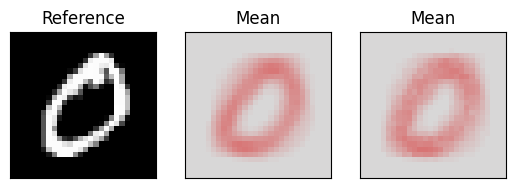

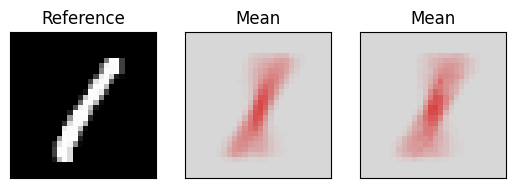

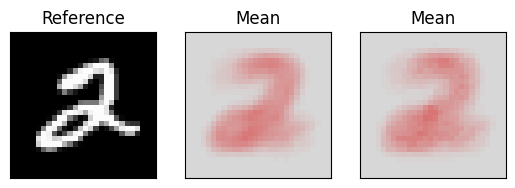

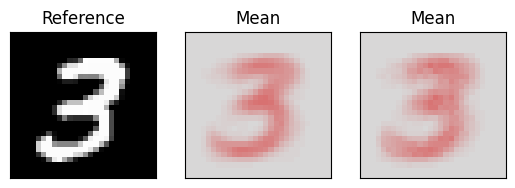

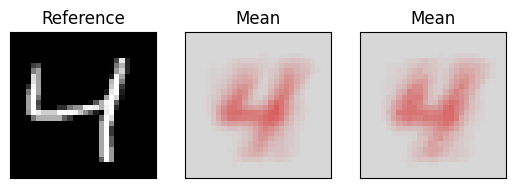

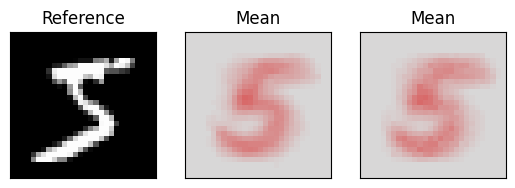

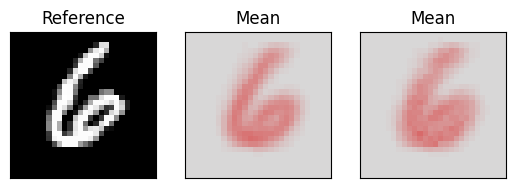

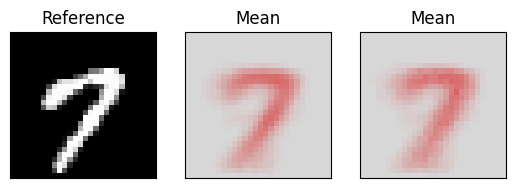

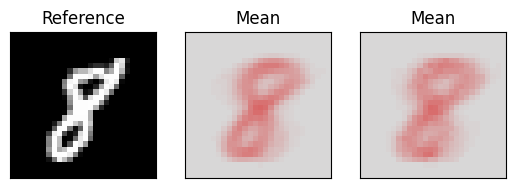

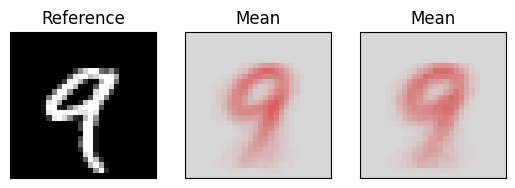

In [40]:
for i in range(10):
    reference = X[T==i][0].reshape((28, 28))
    mean = np.mean(X[T==i], axis=0).reshape((28, 28))
    mean_lrp = np.mean(images[T==i], axis=0).reshape((28, 28))

    fig, axs = plt.subplots(1, 3)
    for j in range(3):
        axs[j].set_xticks([]); axs[j].set_yticks([])

    axs[0].imshow(reference, cmap="gray")
    axs[0].set_title(f"Reference")

    b = 10*(np.abs(mean)**3.0).mean()**(1.0/3)
    axs[1].imshow(mean, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[1].set_title(f"Mean")

    b = 10*(np.abs(mean_lrp)**3.0).mean()**(1.0/3)
    axs[2].imshow(mean_lrp, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    axs[2].set_title(f"Mean")